использовал советы с кагла и этого доклада https://isi-web.org/sites/default/files/2024-02/Handling-Data-Imbalance-in-Machine-Learning.pdf

в этой задаче нам важнее F1 мера

идеи закончились

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from plots import *
from helper import *
import random

In [30]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [31]:
df = pd.read_csv('creditcard.csv')

df.drop(columns=['Time']) # Признак Time содержит количество секунд, прошедших между каждой транзакцией и первой транзакцией в наборе данных.

X, y = divide_data(df, 'Class')


In [32]:
models = [
    ('LogisticRegression', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4)),
    # ('RandomForestClassifier', RandomForestClassifier(random_state=SEED)),
    ('CatBoostClassifier', CatBoostClassifier(random_state=SEED, verbose=False))
]

In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

## Baseline 

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

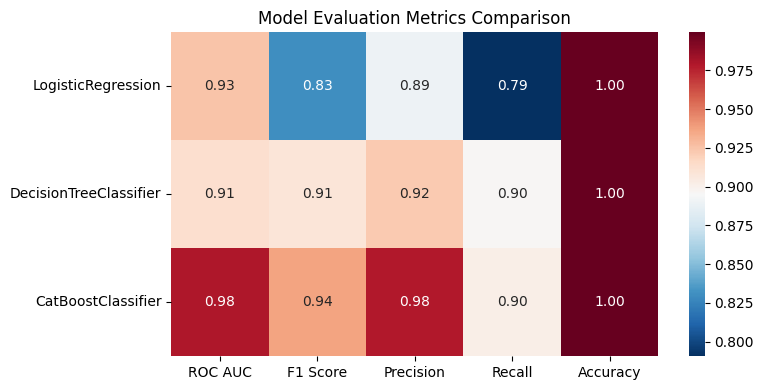

In [34]:
initial_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    cv=cv,
    seed=SEED
)

In [35]:
initial_metrics

,ROC AUC,F1 Score,Precision,Recall,Accuracy
LogisticRegression,0.925175,0.830430,0.889936,0.790516,0.998985
DecisionTreeClassifier,0.912444,0.908745,0.922317,0.896214,0.999389
CatBoostClassifier,0.979427,0.937035,0.978513,0.902401,0.999600


## Откидывание фич

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=SEED,
)

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from catboost import CatBoostClassifier, Pool

def prune_features_catboost(X, y, cat_features=None, test_size=0.3, seed=42,
                             iterations=1000, early_stopping_rounds=50,
                             min_change_pct=10.0, verbose=True, random_state=42):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    y = pd.Series(y).reset_index(drop=True)
    classes = np.unique(y)
    if len(classes) != 2:
        raise ValueError("Только бинарная классификация поддерживается.")
    mapping = {classes[0]: 0, classes[1]: 1}
    y_bin = y.map(mapping).astype(int)
    X_train, X_val, y_train, y_val = train_test_split(X, y_bin, test_size=test_size,
                                                      stratify=y_bin, random_state=seed)
    current_features = list(X.columns)
    if cat_features is None:
        cat_feat_names = None
    else:
        if all(isinstance(cf, int) for cf in cat_features):
            cat_feat_names = [X.columns[i] for i in cat_features]
        else:
            cat_feat_names = [str(cf) for cf in cat_features]
        cat_feat_names = [f for f in cat_feat_names if f in current_features]
    history = []
    while True:
        train_pool = Pool(X_train[current_features], y_train, cat_features=cat_feat_names)
        val_pool = Pool(X_val[current_features], y_val, cat_features=cat_feat_names)
        model = CatBoostClassifier(iterations=iterations, random_seed=random_state,
                                   early_stopping_rounds=early_stopping_rounds, verbose=False)
        model.fit(train_pool, eval_set=val_pool)
        proba = model.predict_proba(X_val[current_features])[:, 1]
        preds = model.predict(X_val[current_features])
        metrics_before = {
            'roc_auc': float(roc_auc_score(y_val, proba)),
            'f1': float(f1_score(y_val, preds)),
            'precision': float(precision_score(y_val, preds)),
            'recall': float(recall_score(y_val, preds))
        }
        importances = model.get_feature_importance(train_pool)
        print(importances)
        print('_'*50)
        if len(importances) != len(current_features):
            raise RuntimeError("Feature importance length mismatch.")
        idx_least = int(np.argmin(importances))
        feature_to_drop = current_features[idx_least]
        if len(current_features) == 1:
            if verbose:
                print("Остался один признак — прекращаю.")
            break
        next_features = [f for f in current_features if f != feature_to_drop]
        next_cat_feat_names = None if cat_feat_names is None else [f for f in cat_feat_names if f in next_features]
        train_pool_next = Pool(X_train[next_features], y_train, cat_features=next_cat_feat_names)
        val_pool_next = Pool(X_val[next_features], y_val, cat_features=next_cat_feat_names)
        model_next = CatBoostClassifier(iterations=iterations, random_seed=random_state,
                                        early_stopping_rounds=early_stopping_rounds, verbose=False)
        model_next.fit(train_pool_next, eval_set=val_pool_next)
        proba_next = model_next.predict_proba(X_val[next_features])[:, 1]
        preds_next = model_next.predict(X_val[next_features])
        metrics_after = {
            'roc_auc': float(roc_auc_score(y_val, proba_next)),
            'f1': float(f1_score(y_val, preds_next)),
            'precision': float(precision_score(y_val, preds_next)),
            'recall': float(recall_score(y_val, preds_next))
        }
        eps = 1e-8
        pct_changes = {}
        for k in metrics_before.keys():
            denom = max(abs(metrics_before[k]), eps)
            pct_changes[k] = 100.0 * (metrics_after[k] - metrics_before[k]) / denom
        max_abs_pct = max(abs(v) for v in pct_changes.values())
        history.append({
            'dropped_feature': feature_to_drop,
            'n_features_before': len(current_features),
            'metrics_before': metrics_before,
            'metrics_after': metrics_after,
            'pct_change': pct_changes,
            'max_abs_pct_change': max_abs_pct
        })
        if verbose:
            print(f"Удалён: {feature_to_drop} | max_abs_pct_change = {max_abs_pct:.2f}%")
        if max_abs_pct > min_change_pct:
            if verbose:
                print(f"Остановка: при удалении '{feature_to_drop}' максимальное изменение {max_abs_pct:.2f}% < {min_change_pct}%")
            break
        current_features = next_features
        cat_feat_names = next_cat_feat_names
    history_df = pd.DataFrame([{
        'dropped_feature': h['dropped_feature'],
        'n_features_before': h['n_features_before'],
        'roc_before': h['metrics_before']['roc_auc'],
        'roc_after': h['metrics_after']['roc_auc'],
        'roc_pct_change': h['pct_change']['roc_auc'],
        'f1_before': h['metrics_before']['f1'],
        'f1_after': h['metrics_after']['f1'],
        'f1_pct_change': h['pct_change']['f1'],
        'precision_before': h['metrics_before']['precision'],
        'precision_after': h['metrics_after']['precision'],
        'precision_pct_change': h['pct_change']['precision'],
        'recall_before': h['metrics_before']['recall'],
        'recall_after': h['metrics_after']['recall'],
        'recall_pct_change': h['pct_change']['recall'],
        'max_abs_pct_change': h['max_abs_pct_change']
    } for h in history])
    result = {
        'final_features': current_features,
        'history': history_df,
        'last_metrics': history[-1]['metrics_after'] if len(history) > 0 else None
    }
    return result

In [38]:
history = prune_features_catboost(
    X_train, y_train,
)

[4.03154832 7.86443331 4.99100683 2.1027294  9.7403895  2.57923193
 1.9847133  2.99872165 4.56510576 2.70471681 1.54425758 2.39756775
 3.51254311 2.84961907 6.88983977 2.5884947  2.08885034 2.93520925
 1.91617373 2.83784845 1.99877113 1.12693271 2.20095123 0.56224863
 2.16444522 2.30990525 7.29647288 0.77207194 2.53268826 5.91251221]
__________________________________________________
Удалён: V23 | max_abs_pct_change = 1.03%
[ 3.76035968 10.03826319  3.00054008  3.11364095  9.45782399  1.54809648
  0.83007188  2.94906256  4.56373554  1.19906929  4.36634784  3.96270429
  1.96484215  4.10358865  4.88359019  1.71181612  1.51768128  3.3353512
  2.5476717   2.03919187  6.04773117  2.1966521   2.15085274  1.95194263
  3.092764    7.07629201  0.94558416  2.41536377  3.22936849]
__________________________________________________
Удалён: V6 | max_abs_pct_change = 2.08%
[ 3.49400465  9.71619441  2.42387321  1.59391217 19.52888698  2.71194904
  2.4107846   3.95572519  0.49759     3.25456674  2.374

In [39]:
history

{'final_features': ['V1', 'V4', 'V12', 'V13', 'V14', 'V26', 'Amount'],
 'history':    dropped_feature  n_features_before  roc_before  roc_after  roc_pct_change  \
 0              V23                 30    0.978025   0.978538        0.052445   
 1               V6                 29    0.978538   0.978803        0.027123   
 2               V9                 28    0.978803   0.979536        0.074849   
 3              V27                 27    0.979536   0.975635       -0.398310   
 4              V16                 26    0.975635   0.980861        0.535716   
 5               V5                 25    0.980861   0.982193        0.135798   
 6              V25                 24    0.982193   0.978705       -0.355189   
 7              V18                 23    0.978705   0.972348       -0.649448   
 8              V24                 22    0.972348   0.978769        0.660297   
 9              V11                 21    0.978769   0.976539       -0.227842   
 10             V20        

In [40]:
with open("feature_prune_history.txt", "w", encoding="utf-8") as f:
    f.write("Итеративное удаление признаков с CatBoost\n\n")
    f.write(f"Итоговый набор признаков ({len(history['final_features'])}): {history['final_features']}\n\n")
    f.write("История удаления:\n")
    for i, row in history['history'].iterrows():
        f.write(f"Шаг {i+1}:\n")
        f.write(f"  Удалён признак: {row['dropped_feature']}\n")
        f.write(f"  Количество признаков до удаления: {row['n_features_before']}\n")
        f.write(f"  Метрики до удаления: roc_auc={row['roc_before']:.4f}, f1={row['f1_before']:.4f}, "
                f"precision={row['precision_before']:.4f}, recall={row['recall_before']:.4f}\n")
        f.write(f"  Метрики после удаления: roc_auc={row['roc_after']:.4f}, f1={row['f1_after']:.4f}, "
                f"precision={row['precision_after']:.4f}, recall={row['recall_after']:.4f}\n")
        f.write(f"  Процентные изменения: roc_auc={row['roc_pct_change']:.2f}%, f1={row['f1_pct_change']:.2f}%, "
                f"precision={row['precision_pct_change']:.2f}%, recall={row['recall_pct_change']:.2f}%\n")
        f.write(f"  Макс. абсолютное изменение: {row['max_abs_pct_change']:.2f}%\n\n")
    f.write(f"Метрики финальной модели: {history['last_metrics']}\n")

## Gaussian Mixture Sampling

вычитал что он вроде неплохо работает с данными после PCA, лучше чем SMOTE

In [41]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


mean_imputer_cols = ['Amount', 'Time']


class GMMSyntheticSampler(BaseEstimator, TransformerMixin):
    def __init__(self, target_col, skip_cols=None, minority_label=1, 
                 max_components=10, n_samples=100, seed=SEED, return_only_new=False):
        self.target_col = target_col
        self.skip_cols = skip_cols if skip_cols is not None else []
        self.minority_label = minority_label
        self.max_components = max_components
        self.n_samples = n_samples
        self.seed = seed
        self.return_only_new = return_only_new

    def fit(self, X, y=None):
        df = X.copy()
        self.input_features_ = df.columns.to_list()

        X_minority = df[df[self.target_col] == self.minority_label]

        self.cols_gmm_ = [c for c in df.columns if c not in self.skip_cols and c != self.target_col]

        X_train = X_minority[self.cols_gmm_]

        lowest_bic = np.inf
        best_k = None
        for k in range(1, self.max_components):
            gmm = GaussianMixture(n_components=k, random_state=self.seed)
            gmm.fit(X_train)
            bic = gmm.bic(X_train)
            if bic < lowest_bic:
                lowest_bic = bic
                best_k = k

        self.best_k_ = best_k
        self.gmm_ = GaussianMixture(n_components=best_k, random_state=self.seed)
        self.gmm_.fit(X_train)

        return self

    def transform(self, X):
        df = X.copy()

        X_new, _ = self.gmm_.sample(self.n_samples)
        df_new = pd.DataFrame(X_new, columns=self.cols_gmm_)
        df_new[self.target_col] = self.minority_label

        for col in df.columns:
            if col not in df_new.columns:
                df_new[col] = np.nan

        df_new = df_new[df.columns]

        if self.return_only_new:
            return df_new.reset_index(drop=True)
        else:
            result = pd.concat([df, df_new], ignore_index=True)
        return result
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(self.input_features_)
        return np.array(input_features)


# Пример пайплайна
preprocessor = Pipeline([
    ('gmm_sampler', GMMSyntheticSampler(
        target_col='Class', 
        skip_cols = mean_imputer_cols,
        minority_label=1, 
        max_components=10, 
        n_samples=500, 
        seed=SEED,
        return_only_new=False
    )),
    ('nan_remover', ColumnTransformer(
        [
        ('mean', SimpleImputer(strategy='mean'), mean_imputer_cols)
        ],
        remainder='passthrough', 
        verbose_feature_names_out=False))
])

preprocessor.set_output(transform="pandas")

df_augmented = preprocessor.fit_transform(df)

In [42]:
df_augmented

,Amount,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,149.620000,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,2.690000,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,378.660000,1.000000,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,123.500000,1.000000,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,69.990000,2.000000,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285302,88.349619,94813.859575,-13.193305,12.785145,-9.907107,3.321272,-4.800829,5.761236,-18.749917,-37.353363,...,-3.492750,27.202546,-8.885659,5.305556,-0.639659,0.262892,-0.107189,1.268630,0.939974,1
285303,88.349619,94813.859575,-13.192254,12.785831,-9.905940,3.319966,-4.803036,5.760768,-18.751543,-37.352800,...,-3.491019,27.201622,-8.885868,5.304162,-0.640571,0.264419,-0.109290,1.267891,0.939950,1
285304,88.349619,94813.859575,-13.192388,12.785457,-9.906818,3.321676,-4.799364,5.761896,-18.750768,-37.353728,...,-3.493761,27.202720,-8.885702,5.305240,-0.638521,0.261773,-0.107820,1.267690,0.939270,1
285305,88.349619,94813.859575,-13.193696,12.785439,-9.906762,3.321182,-4.801593,5.760874,-18.752211,-37.354783,...,-3.493057,27.203522,-8.888442,5.303400,-0.640181,0.263846,-0.107401,1.269264,0.940667,1


In [43]:
df_augmented['Class'].value_counts() # посмотрим на таргет

Class
0    284315
1       992
Name: count, dtype: int64

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

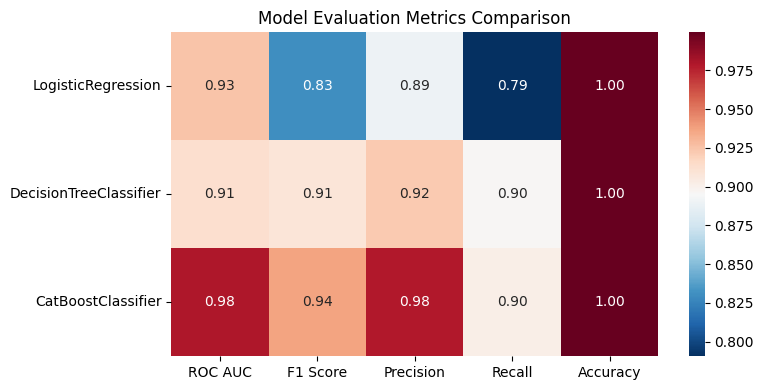

In [44]:
gms_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    cv=cv,
    seed=SEED,
    preprocessor=preprocessor
)

In [45]:
gms_metrics

,ROC AUC,F1 Score,Precision,Recall,Accuracy
LogisticRegression,0.925175,0.830430,0.889936,0.790516,0.998985
DecisionTreeClassifier,0.912444,0.908745,0.922317,0.896214,0.999389
CatBoostClassifier,0.979427,0.937035,0.978513,0.902401,0.999600


(<Figure size 800x400 with 2 Axes>,
                         ROC AUC  F1 Score  Precision  Recall  Accuracy
 LogisticRegression          0.0       0.0        0.0     0.0       0.0
 DecisionTreeClassifier      0.0       0.0        0.0     0.0       0.0
 CatBoostClassifier          0.0       0.0        0.0     0.0       0.0)

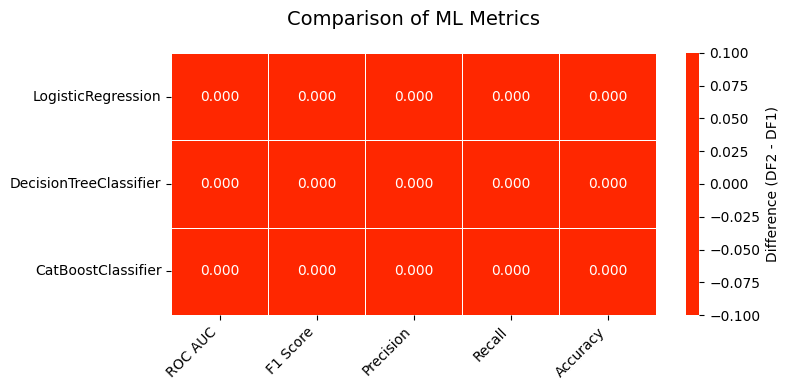

In [46]:
compare_metrics_heatmap(initial_metrics, gms_metrics)

## Undersampling

попробуем удалить часть отрицательного класса сделав соотношение 1/10

In [47]:
positive_df = df[df['Class'] == 1]
negative_df = df[df['Class'] == 0]

negative_sample = negative_df.sample(n=5000, random_state=SEED)

balanced_df = pd.concat([positive_df, negative_sample], ignore_index=True)

balanced_df = balanced_df.sample(frac=1, random_state=SEED).reset_index(drop=True)

X_balanced, y_balanced = divide_data(balanced_df, 'Class')

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

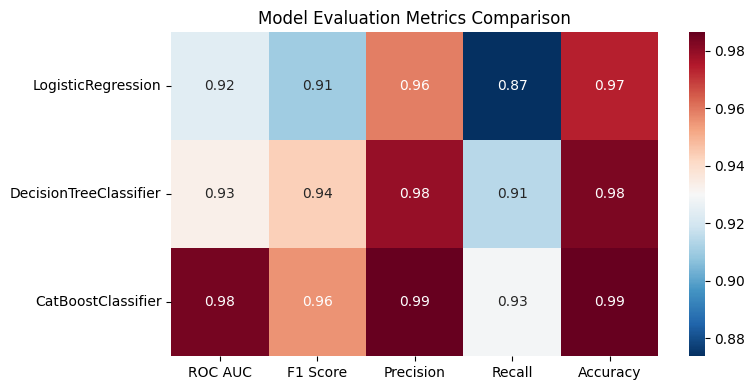

In [48]:
balanced_metrics = train_evaluate_models_cv(
    models=models,
    X=X_balanced,
    y=y_balanced,
    cv=cv,
    seed=SEED
)

In [49]:
balanced_metrics

,ROC AUC,F1 Score,Precision,Recall,Accuracy
LogisticRegression,0.923788,0.910111,0.959038,0.873818,0.973599
DecisionTreeClassifier,0.933321,0.943665,0.978946,0.914505,0.982884
CatBoostClassifier,0.983959,0.955203,0.986276,0.929198,0.986342


(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.001387  0.079682   0.069101  0.083303 -0.025386
 DecisionTreeClassifier  0.020876  0.034920   0.056629  0.018291 -0.016505
 CatBoostClassifier      0.004532  0.018168   0.007763  0.026797 -0.013257)

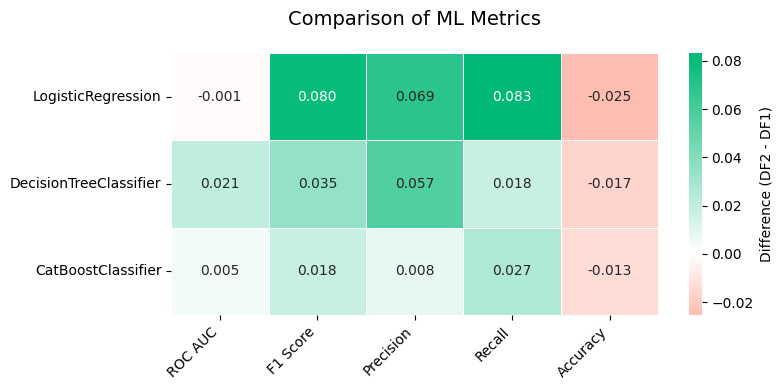

In [50]:
compare_metrics_heatmap(initial_metrics, balanced_metrics)

recall подрос - хорошо

попробуем взять больше негативных. соотношение 1/100

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

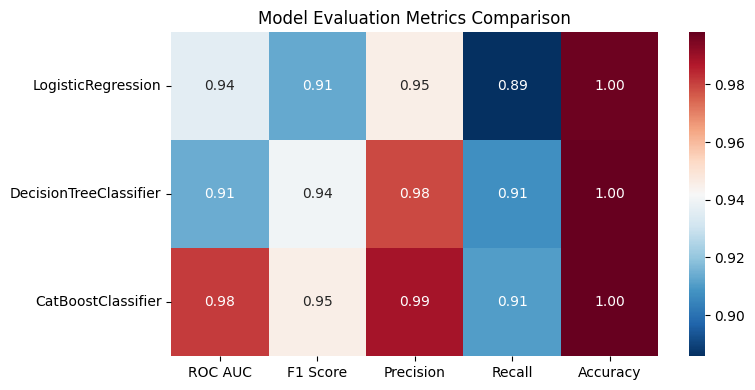

,ROC AUC,F1 Score,Precision,Recall,Accuracy
LogisticRegression,0.936006,0.912914,0.945813,0.885687,0.996851
DecisionTreeClassifier,0.913829,0.939926,0.978940,0.907344,0.997861
CatBoostClassifier,0.981060,0.945691,0.988549,0.910444,0.998079


In [51]:
positive_df = df[df['Class'] == 1]
negative_df = df[df['Class'] == 0]

negative_sample = negative_df.sample(n=50000, random_state=SEED)

balanced_df2 = pd.concat([positive_df, negative_sample], ignore_index=True)

balanced_df2 = balanced_df2.sample(frac=1, random_state=SEED).reset_index(drop=True)

X_balanced, y_balanced = divide_data(balanced_df2, 'Class')

balanced_metrics2 = train_evaluate_models_cv(
    models=models,
    X=X_balanced,
    y=y_balanced,
    cv=cv,
    seed=SEED
)

balanced_metrics2

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.012217  0.002803  -0.013225  0.011869  0.023252
 DecisionTreeClassifier -0.019492 -0.003739  -0.000006 -0.007161  0.014977
 CatBoostClassifier     -0.002899 -0.009511   0.002273 -0.018754  0.011737)

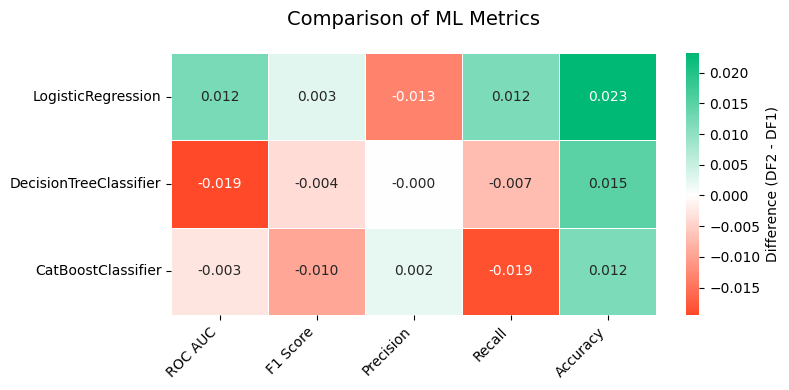

In [52]:
compare_metrics_heatmap(balanced_metrics, balanced_metrics2)

стало хуже

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.010830  0.082484   0.055876  0.095172 -0.002134
 DecisionTreeClassifier  0.001385  0.031180   0.056623  0.011130 -0.001528
 CatBoostClassifier      0.001633  0.008657   0.010037  0.008043 -0.001521)

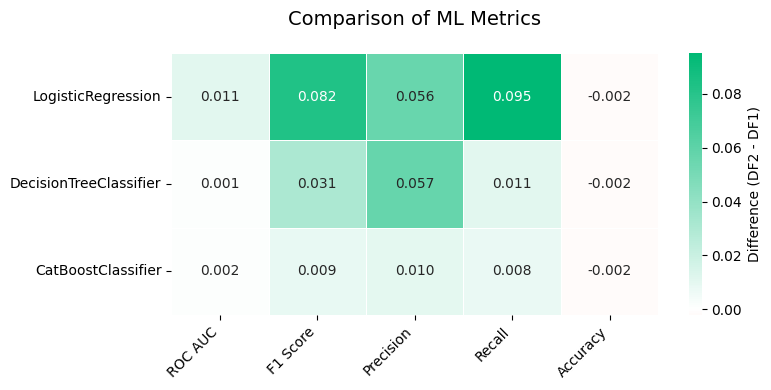

In [53]:
compare_metrics_heatmap(initial_metrics, balanced_metrics2)

## Class balancing

попробуем подобрать коэффициенты

In [54]:
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

class_weights

{np.int64(0): np.float64(0.5008652375006595),
 np.int64(1): np.float64(289.4380081300813)}

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

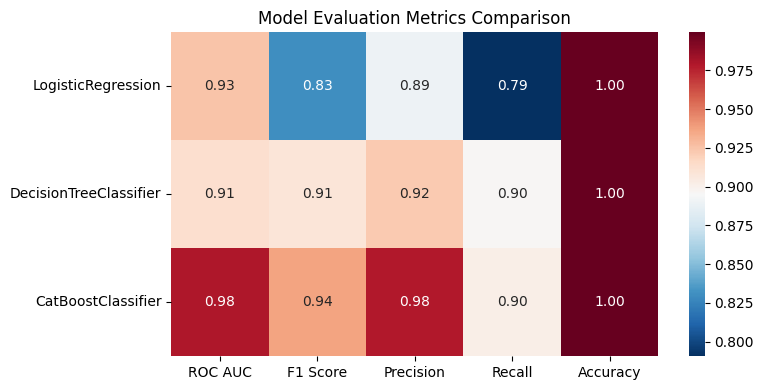

In [55]:
models2 = [
    ('LogisticRegression', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4)),
    # ('RandomForestClassifier', RandomForestClassifier(random_state=SEED)),
    ('CatBoostClassifier', CatBoostClassifier(random_state=SEED, verbose=False, class_weights=class_weights))
]

weight_balanced_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    cv=cv,
    seed=SEED
)

In [56]:
weight_balanced_metrics

,ROC AUC,F1 Score,Precision,Recall,Accuracy
LogisticRegression,0.925175,0.830430,0.889936,0.790516,0.998985
DecisionTreeClassifier,0.912444,0.908745,0.922317,0.896214,0.999389
CatBoostClassifier,0.979427,0.937035,0.978513,0.902401,0.999600


(<Figure size 800x400 with 2 Axes>,
                         ROC AUC  F1 Score  Precision  Recall  Accuracy
 LogisticRegression          0.0       0.0        0.0     0.0       0.0
 DecisionTreeClassifier      0.0       0.0        0.0     0.0       0.0
 CatBoostClassifier          0.0       0.0        0.0     0.0       0.0)

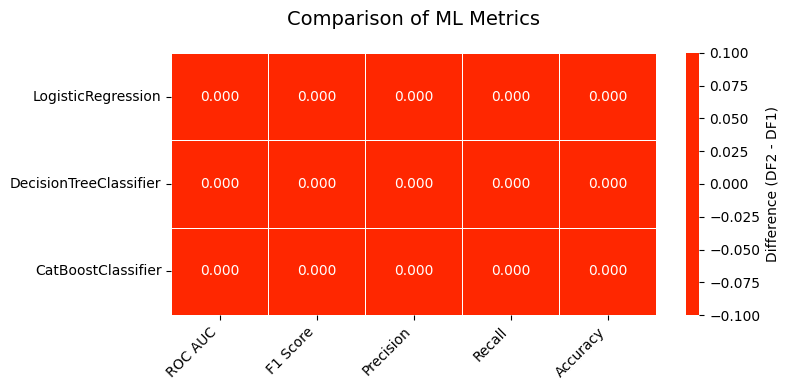

In [57]:
compare_metrics_heatmap(initial_metrics, weight_balanced_metrics)

нет изменений

## Isolated forest

In [58]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

iso = IsolationForest(random_state=SEED, contamination=0.00173)
iso.fit(X)

# предсказываем: 1 — нормальный, -1 — аномалия
y_pred = iso.predict(X)

y_pred_bin = [0 if x==1 else 1 for x in y_pred]

roc = roc_auc_score(y, y_pred_bin)
f1 = f1_score(y, y_pred_bin)
precision = precision_score(y, y_pred_bin)
recall = recall_score(y, y_pred_bin)

roc, f1, precision, recall

(0.6274033695879226,
 0.25583756345177666,
 0.25557809330628806,
 0.25609756097560976)

показатели не воодушевляют